In [1]:
import os
import pickle
from src import RESULT_DIR, DATA_DIR
import lightgbm as lgb
from src.dataset import VDAODataset
from torch.utils.data import DataLoader
import torch
from src.resnet import Resnet50
from src.utils import threshold, opening, closing, voting_window
import numpy as np
from src.utils import MCC
from sklearn.metrics import matthews_corrcoef
from src.utils import MCC, DIS, conf_mat

import matplotlib.pyplot as plt

# Resnet50
resnet = Resnet50('cuda' if torch.cuda.is_available() else 'cpu')

/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /nfs/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
res_params = pickle.load(open(os.path.join(RESULT_DIR, 
                                           'hyperparameter_search.pkl'), 'rb'))

In [4]:
fold = 1
res_hp = res_params['LightGBM']['warp'][fold]


In [5]:
# Storing best hyperparameters
num_leaves = res_hp['num_leaves']
min_child = res_hp['min_child_samples']
threshold_post = res_hp['threshold_post']
opening_value = res_hp['opening']
closing_value = res_hp['closing']
voting_width = res_hp['voting_width']
voting_depth = res_hp['voting_depth']
count = res_hp['count']

num_leaves, min_child, res_hp['threshold']

(153, 200, 0.15)

In [8]:
for fold in range(1, 10):
    
    res_hp = res_params['LightGBM']['warp'][fold]
    num_leaves = res_hp['num_leaves']
    min_child = res_hp['min_child_samples']
    threshold_post = res_hp['threshold_post']
    opening_value = res_hp['opening']
    closing_value = res_hp['closing']
    voting_width = res_hp['voting_width']
    voting_depth = res_hp['voting_depth']
    count = res_hp['count']

    print(num_leaves, min_child, res_hp['threshold'], res_hp['num_trees'])

153 200 0.15 280
256 200 0.12 265
186 200 0.12 287
191 174 0.16 278
182 200 0.2 288
166 174 0.16 295
155 197 0.18 292
181 200 0.11 263
92 144 0.15 291


In [4]:

# Create params dict
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'goss',
    'learning_rate': 0.1,
    'lambda_l1': 1e-4,
    'early_stopping': 30,
    'num_booster_rounds': 300,
    'force_col_wise': 'true',
    'verbosity': -1,
    'num_leaves': num_leaves,
    'min_child_samples': min_child,
    'device_type': 'cpu',
    'n_jobs': 4
}
params_dataset = {'two_round': True, 'header': False, 'verbosity': -1}


In [5]:
out_dir = os.path.join(DATA_DIR, 'test_classifier', 'data')

train_bin_file = lgbm_trn = os.path.join(
        out_dir, '{0}_{1}_fold{2:02d}_trn.pkl'.format('LightGBM', 'warp',
                                                      fold))
val_bin_file = train_bin_file.replace('trn', 'val')
train_full_bin_file = train_bin_file.replace('trn', 'trn_full')

lgb_train = lgb.Dataset(data=train_bin_file,
                        params=params_dataset).construct()
lgb_val = lgb.Dataset(data=val_bin_file,
                      params=params_dataset,
                      reference=lgb_train).construct()
lgb_trn_full = lgb.Dataset(data=train_full_bin_file,
                           params=params_dataset).construct()


In [8]:
lgb_class = lgb.train(lgb_params,
                      lgb_train,
                      valid_sets=[lgb_val],
                      valid_names=['validation'],
                      keep_training_booster=True,
                      num_boost_round=lgb_params['num_booster_rounds'])


/home/luiz.tavares/.local/miniconda3/envs/pixel_env/lib/python3.10/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	validation's auc: 0.920878
Training until validation scores don't improve for 30 rounds
[2]	validation's auc: 0.93092
[3]	validation's auc: 0.937628
[4]	validation's auc: 0.94618
[5]	validation's auc: 0.950516
[6]	validation's auc: 0.953132
[7]	validation's auc: 0.955841
[8]	validation's auc: 0.958618
[9]	validation's auc: 0.96062
[10]	validation's auc: 0.963228
[11]	validation's auc: 0.965077
[12]	validation's auc: 0.966892
[13]	validation's auc: 0.968602
[14]	validation's auc: 0.969948
[15]	validation's auc: 0.971542
[16]	validation's auc: 0.972629
[17]	validation's auc: 0.973976
[18]	validation's auc: 0.975369
[19]	validation's auc: 0.976546
[20]	validation's auc: 0.977526
[21]	validation's auc: 0.978524
[22]	validation's auc: 0.97918
[23]	validation's auc: 0.980096
[24]	validation's auc: 0.980798
[25]	validation's auc: 0.98138
[26]	validation's auc: 0.981953
[27]	validation's auc: 0.982541
[28]	validation's auc: 0.982975
[29]	validation's auc: 0.983633
[30]	validation's auc: 0.

In [6]:
dataset = VDAODataset(fold=fold,
                      split=-1,
                      type='test',
                      alignment='warp',
                      transform=True)
loader = DataLoader(dataset, num_workers=8, batch_size=1, shuffle=False)

prd_tns = torch.zeros((201, 90, 160))
sil_tns = torch.zeros((201, 90, 160))

In [53]:
cls2 = pickle.load(open('/home/luiz.tavares/Workspace/VDAO_Pixel/data/test_classifier/classifiers/LightGBM_warp_fold04.pkl', 'rb'))

data = pickle.load(open('/home/luiz.tavares/Workspace/VDAO_Pixel/data/test_classifier/result_data/LightGBM_warp_fold04.pkl', 'rb'))
prd_tns2 = data['prediction'][5]

In [ ]:
for i, (ref_frame, tar_frame, sil_frame,
        info) in enumerate(loader):
    print(i, end='\r')
    if i>200:
        break
    
    # Concatenating tensors
    feat_tar = resnet.get_features(tar_frame, 'residual3')
    feat_ref = resnet.get_features(ref_frame, 'residual3')
    feat = torch.cat((feat_tar, feat_ref), 0)
    X = feat.view(512, -1).T

    # Silhouettte
    sil = sil_frame[0, 0, ::4, ::4] * 255
    sil[sil < 85] = 0
    sil[(sil <= 170) & (sil >= 85)] = 0.5
    sil[sil > 170] = 1


    y = cls2.predict(X).reshape((90, 160))
    

    prd_tns[i, :, :] = torch.Tensor(y)
    sil_tns[i, :, :] = sil


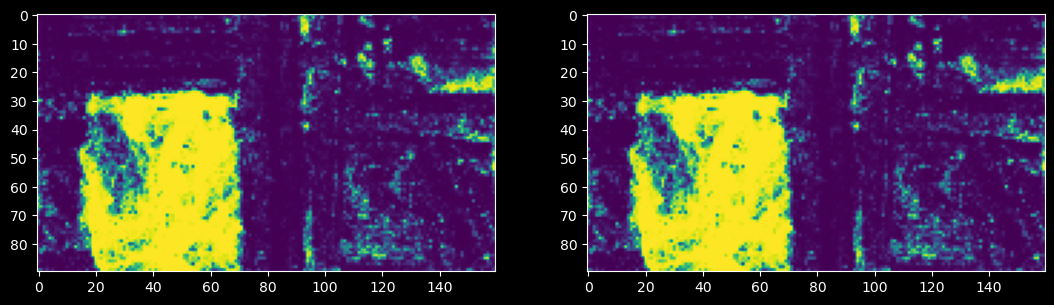

In [54]:
# pickle.dump(prd_tns ,open('/home/luiz.tavares/Workspace/VDAO_Pixel/data/test_classifier/result_data/frames_test.pkl', 'wb'))
# prd_saved = pickle.load(open('/home/luiz.tavares/Workspace/VDAO_Pixel/data/test_classifier/result_data/frames_test.pkl', 'rb'))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,8))
ax1.imshow(prd_saved[200, :, :])
ax2.imshow(prd_tns2[200, :, :])

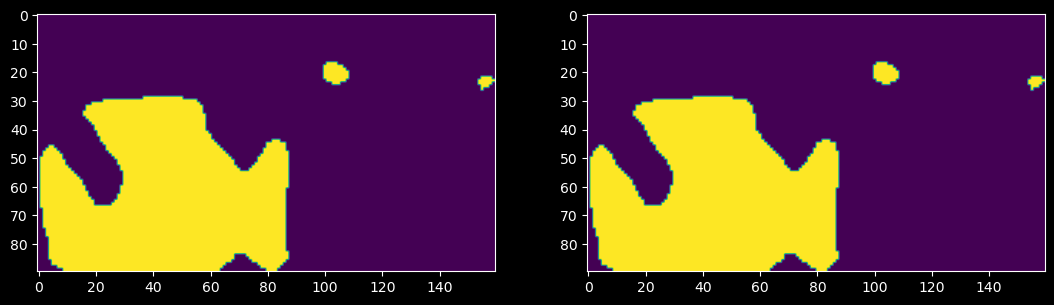

In [55]:
vid = threshold(prd_tns, threshold_post)
vid = opening(vid, opening_value)
vid = closing(vid, closing_value)
vid = voting_window(vid, (voting_depth, voting_width, voting_width), count / 100)

vid2 = threshold(prd_tns2, threshold_post)
vid2 = opening(vid2, opening_value)
vid2 = closing(vid2, closing_value)
vid2 = voting_window(vid2, (voting_depth, voting_width, voting_width), count / 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,8))
ax1.imshow(vid[150, :, :])
ax2.imshow(vid2[150, :, :])

In [56]:
# treating sil

# confusion matrix
res_out = vid.reshape(-1)
sil_out = sil_tns.reshape(-1).numpy()

valid_pix = np.where(sil_out != 0.5)
tn, fp, fn, tp = conf_mat(sil_out[valid_pix], res_out[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

print(mcc, dis)

tn, fp, fn, tp = conf_mat(sil_out[valid_pix], 
                          vid2.reshape(-1)[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

print(mcc, dis)

0.8317034731190457 0.21873137565825995
0.8317034731190457 0.21873137565825995


### Full dataset test

In [6]:
out_dir = os.path.join(DATA_DIR, 'test_classifier', 'data')

train_bin_file = lgbm_trn = os.path.join(
        out_dir, '{0}_{1}_fold{2:02d}_trn.pkl'.format('LightGBM', 'warp',
                                                      fold))
train_full_bin_file = train_bin_file.replace('trn', 'trn_full')

params_dataset = {'two_round': True, 'header': False, 'verbosity': -1}
lgb_trn_full = lgb.Dataset(data=train_full_bin_file,
                           params=params_dataset).construct()


In [22]:
# Create params dict
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'goss',
    'learning_rate': 0.1,
    'lambda_l1': 1e-4,
#    'early_stopping': 30,
    'num_booster_rounds': 800,
    'force_col_wise': 'true',
    'verbosity': -1,
    'num_leaves': num_leaves,
    'min_child_samples': min_child,
    'device_type': 'cpu',
    'n_jobs': 4
}

lgb_class = lgb.train(lgb_params,
                      lgb_trn_full,
                      keep_training_booster=True,
                      num_boost_round=lgb_params['num_booster_rounds'])


In [23]:
dataset = VDAODataset(fold=fold,
                      split=-1,
                      type='test',
                      alignment='warp',
                      transform=True)
loader = DataLoader(dataset, num_workers=8, batch_size=1, shuffle=False)

prd_tns = torch.zeros((201, 90, 160))
sil_tns = torch.zeros((201, 90, 160))

In [24]:
for i, (ref_frame, tar_frame, sil_frame,
        info) in enumerate(loader):
    print(i, end='\r')
    if i>200:
        break
    
    # Concatenating tensors
    feat_tar = resnet.get_features(tar_frame, 'residual3')
    feat_ref = resnet.get_features(ref_frame, 'residual3')
    feat = torch.cat((feat_tar, feat_ref), 0)
    X = feat.view(512, -1).T

    # Silhouettte
    sil = sil_frame[0, 0, ::4, ::4] * 255
    sil[sil < 85] = 0
    sil[(sil <= 170) & (sil >= 85)] = 0.5
    sil[sil > 170] = 1


    y = lgb_class.predict(X.numpy()).reshape((90, 160))
    

    prd_tns[i, :, :] = torch.Tensor(y)
    sil_tns[i, :, :] = sil

In [25]:
vid = threshold(prd_tns, threshold_post)
vid = opening(vid, opening_value)
vid = closing(vid, closing_value)
vid = voting_window(vid, (voting_depth, voting_width, voting_width), count / 100)

# confusion matrix
res_out = vid.reshape(-1)
sil_out = sil_tns.reshape(-1).numpy()

valid_pix = np.where(sil_out != 0.5)
tn, fp, fn, tp = conf_mat(sil_out[valid_pix], res_out[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

print(mcc, dis)

0.8458734296643715 0.18759493540343042


In [ ]:
0.841289724241032 0.20023670286502276